In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, assemble, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.quantumcircuitdata import QuantumCircuitData, CircuitInstruction
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.library.standard_gates.h import *
import qiskit
import numpy as np
from circuit_remapper import *
from components.layer import *

import warnings

warnings.filterwarnings("ignore")

C:\Users\anura\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def measure_sim(qc, samples=20000):
    backend = Aer.get_backend('statevector_simulator')
    circuit = transpile(qc, backend=backend)
    #     print(circuit)
    job = execute(qc, backend, shots=samples)
    counts = job.result().get_counts()
#     print("Job result: ", job.result())
    return counts

##### TEST for TOPOLOGY

In [3]:
# Write a q_map as dictionary
n_q, n_e = 10, 3
qr0 = QuantumRegister(n_q, 'qr0')
qr1 = QuantumRegister(n_e, 'qr1')
q_map = {
    "QPU_1" : [Qubit(qr0, i) for i in range(3)],
    "QPU_2" : [Qubit(qr0, i) for i in range(3,7)],
    "QPU_3" : [Qubit(qr0, i) for i in range(7,n_q)]
}
e_map = {
    "QPU_1" : Qubit(qr1, 0),
    "QPU_2" : Qubit(qr1, 1),
    "QPU_3" : Qubit(qr1, 2)
}
q_map

{'QPU_1': [Qubit(QuantumRegister(10, 'qr0'), 0),
  Qubit(QuantumRegister(10, 'qr0'), 1),
  Qubit(QuantumRegister(10, 'qr0'), 2)],
 'QPU_2': [Qubit(QuantumRegister(10, 'qr0'), 3),
  Qubit(QuantumRegister(10, 'qr0'), 4),
  Qubit(QuantumRegister(10, 'qr0'), 5),
  Qubit(QuantumRegister(10, 'qr0'), 6)],
 'QPU_3': [Qubit(QuantumRegister(10, 'qr0'), 7),
  Qubit(QuantumRegister(10, 'qr0'), 8),
  Qubit(QuantumRegister(10, 'qr0'), 9)]}

###### Test for topology class methods

In [4]:
circuit_topo = Topology(q_map,e_map)

print("Total Number of Qubits in Topology : ", circuit_topo.num_qubits())
print("Total Number of QPUs in Topology: ", circuit_topo.num_hosts())

Qubit1 = q_map["QPU_1"][2]
Qubit2 = q_map["QPU_3"][1]
print("{} and {} are adjacent".format(Qubit1, Qubit2) 
      if circuit_topo.are_adjacent(Qubit1, Qubit2) else 
      "{} and {} are not adjacent".format(Qubit1, Qubit2))

for qubit in circuit_topo.qubits:
    print("Qubit: {} --------- Host: {}".format(qubit, circuit_topo.get_host(qubit)))

Total Number of Qubits in Topology :  10
Total Number of QPUs in Topology:  3
Qubit(QuantumRegister(10, 'qr0'), 2) and Qubit(QuantumRegister(10, 'qr0'), 8) are not adjacent
Qubit: Qubit(QuantumRegister(10, 'qr0'), 0) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 1) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 2) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 3) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 4) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 5) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 6) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 7) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(10, 'qr0'), 8) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(10, 'qr0'), 9) --------- Host: QPU_3


##### Test for circuit remapper defined in layer.py

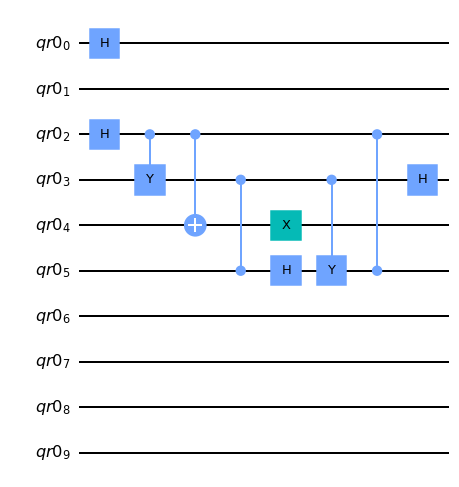

In [5]:
qc = QuantumCircuit(qr0)
qc.h(0),qc.h(2)
# qc.cx(0,1)
# qc.cx(2,0)
qc.cy(2,3)
qc.cx(2,4)
qc.cz(3,5)
qc.h(5)
qc.cy(3,5)
qc.cz(2,5)
# qc.cx(1,4)
# qc.cu(0,2,3,1,4,0)
# qc.cx(5,9)
qc.x(4)
qc.h(3)
qc.draw(output='mpl')

In [6]:
circ_object = CircuitRemapper(circuit_topo)
layers_here = circ_object._circuit_to_layers(qc)
layers_here

[[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 2),), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cy', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 2), Qubit(QuantumRegister(10, 'qr0'), 3)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 2), Qubit(QuantumRegister(10, 'qr0'), 4)), clbits=()),
  CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 3), Qubit(QuantumRegister(10, 'qr0'), 5)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegi

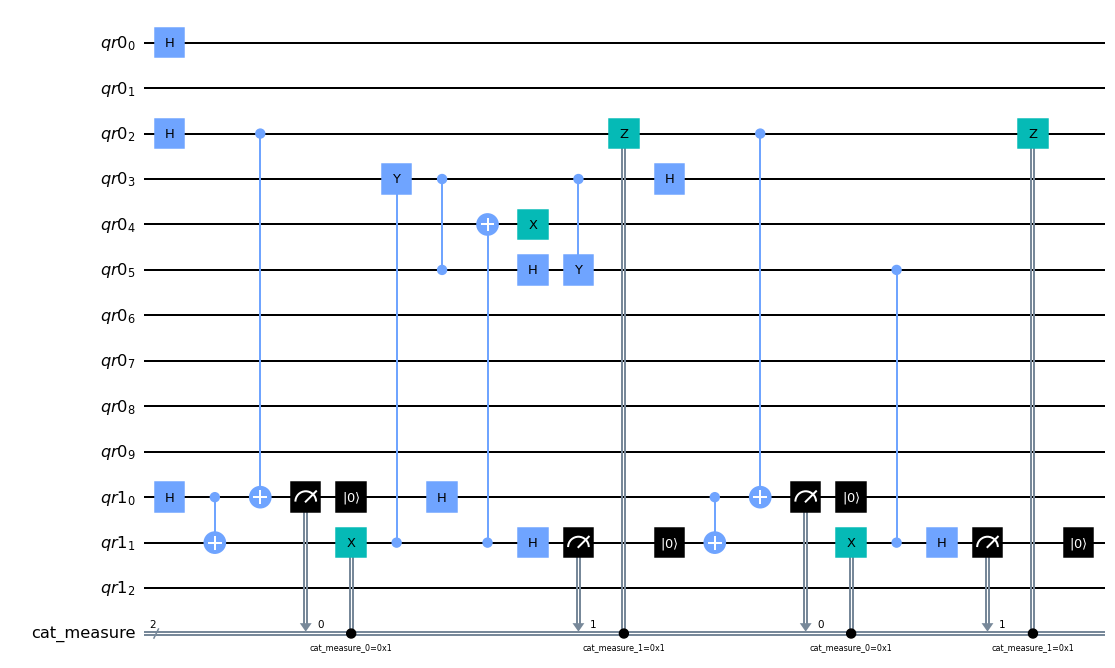

In [7]:
dist_circ = circ_object.remap_circuit(qc)
dist_circ.draw(output='mpl')

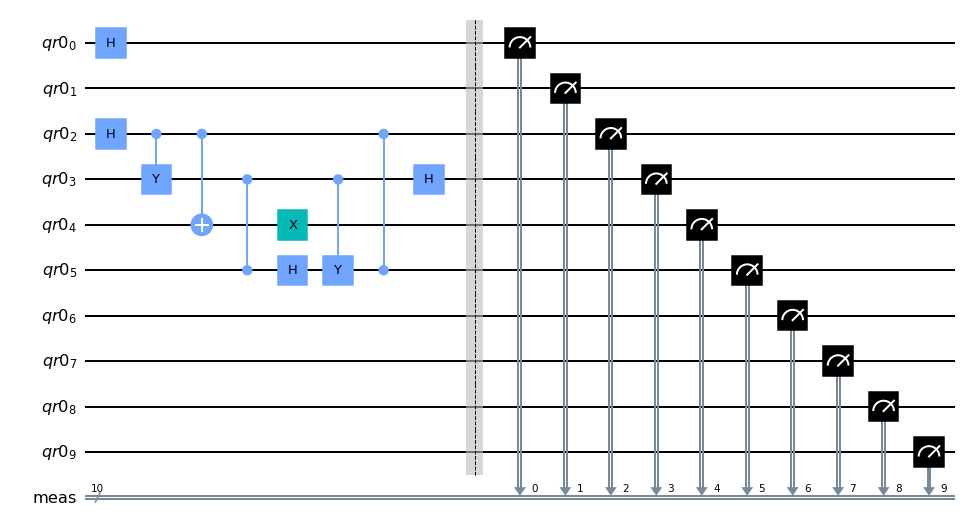

In [8]:
qc.measure_all()
qc.draw('mpl')

{'0000111001': 1207, '0000110001': 1316, '0000000100': 1251, '0000101101': 1230, '0000011001': 1307, '0000010001': 1274, '0000000101': 1268, '0000011000': 1221, '0000010000': 1256, '0000110000': 1264, '0000111000': 1147, '0000100101': 1218, '0000100100': 1257, '0000001101': 1232, '0000001100': 1245, '0000101100': 1307}


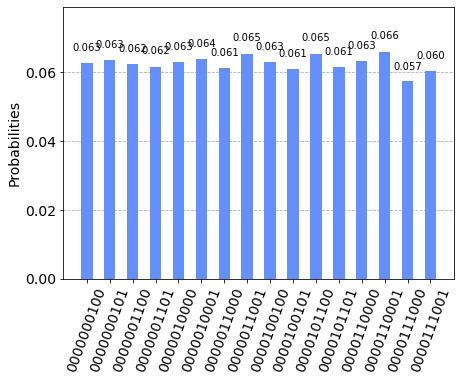

In [9]:
sim_count = measure_sim(qc=qc)
print(sim_count)
plot_histogram(sim_count) 

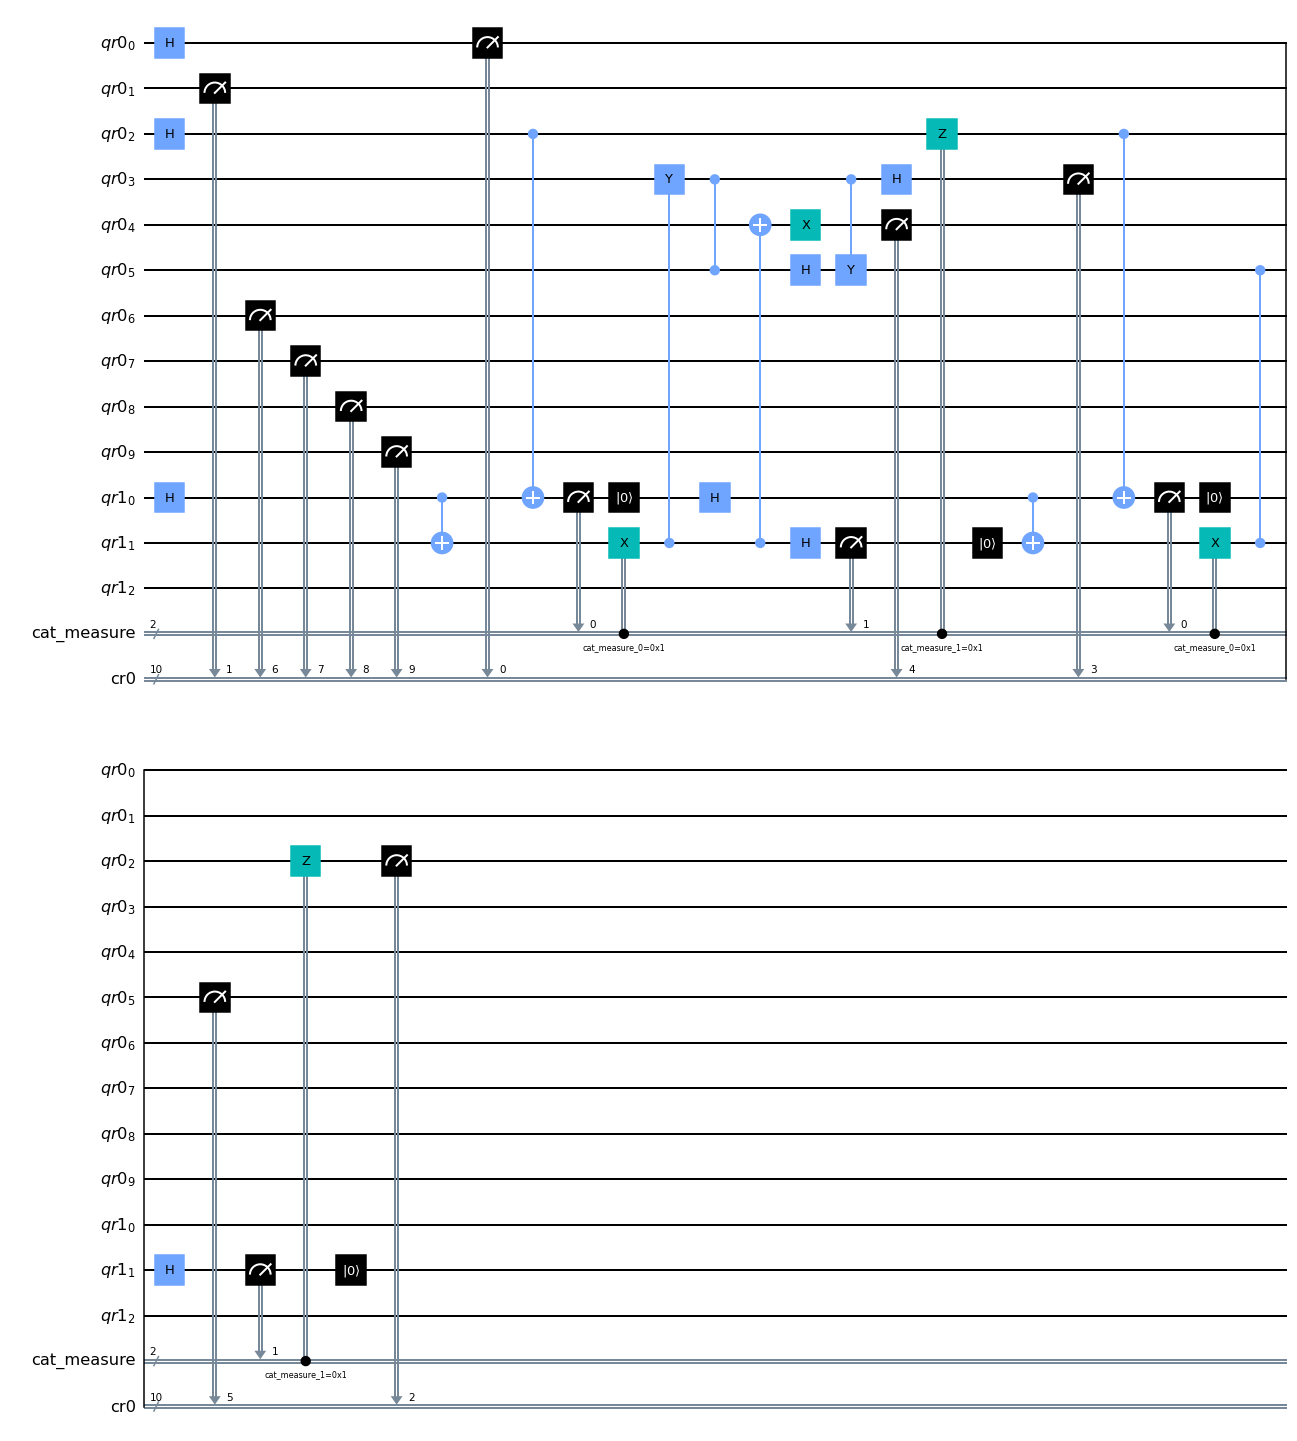

In [10]:
cr0 = ClassicalRegister(n_q, 'cr0')
dist_circ.add_register(cr0)
dist_circ.measure(qr0,cr0)
dist_circ.draw(output='mpl')

{'0000100101': 1234, '0000110000': 1206, '0000111000': 1280, '0000010000': 1179, '0000001100': 1312, '0000111001': 1250, '0000001101': 1209, '0000010001': 1240, '0000011001': 1218, '0000101101': 1254, '0000101100': 1274, '0000110001': 1235, '0000100100': 1320, '0000000100': 1286, '0000000101': 1265, '0000011000': 1238}


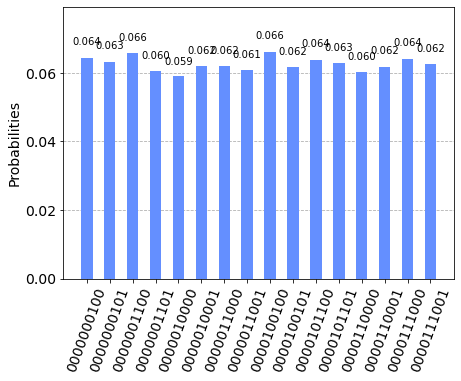

In [11]:
dist_sim_count = measure_sim(qc=dist_circ)
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [12]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

##### Cat Entangler check

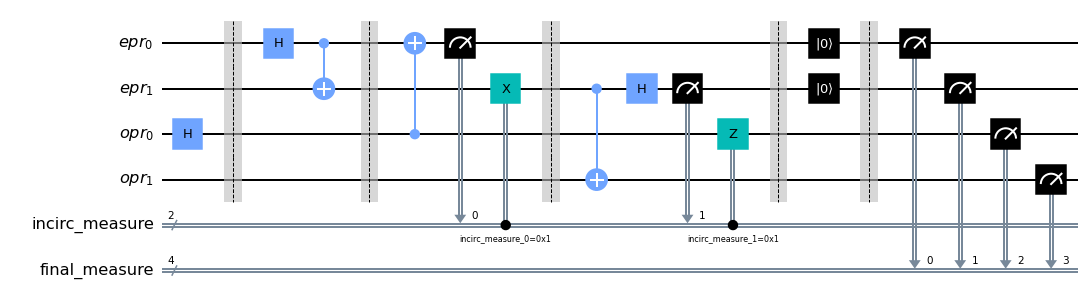

In [13]:
epr_qubits = QuantumRegister(2, "epr")
opr_qubits = QuantumRegister(2, "opr")
measure_bits = ClassicalRegister(2, "incirc_measure")
final_cbits = ClassicalRegister(4, "final_measure")
qc = QuantumCircuit(epr_qubits, opr_qubits, measure_bits, final_cbits)

#check for opr_1 = 1 and opr_2 = 1

qc.h(2)

# qc.x(3)
qc.barrier()

# Generate EPR pair
qc.h(0)
qc.cx(0, 1)
qc.barrier()
# cat entanglement
qc.cx(2,0)
qc.measure(0,0)
qc.x(1).c_if(measure_bits[0], 1)
qc.barrier()
qc.cx(1,3)
qc.h(1)
qc.measure(1,1)
qc.z(2).c_if(measure_bits[1], 1)
qc.barrier()
qc.reset(epr_qubits)

## Measurements
qc.barrier()
qc.measure(epr_qubits, final_cbits[0:2])
qc.measure(opr_qubits, final_cbits[2:4])

qc.draw(output='mpl')

{'00': 9867, '11': 10133}


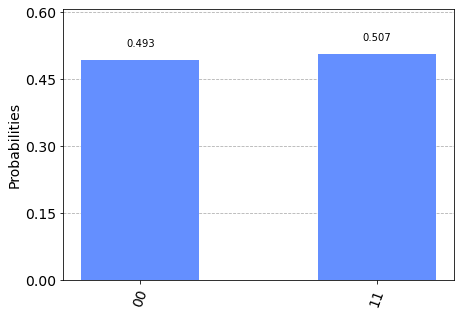

In [14]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=qc)
sim_count = CircuitRemapper.collate_measurements(sim_count, 2)
print(sim_count)
plot_histogram(sim_count)  # Display the output on measurement of state vector

The cat entangling scheme works

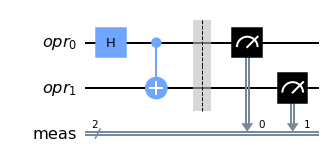

In [15]:
qc = QuantumCircuit(opr_qubits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw(output='mpl')

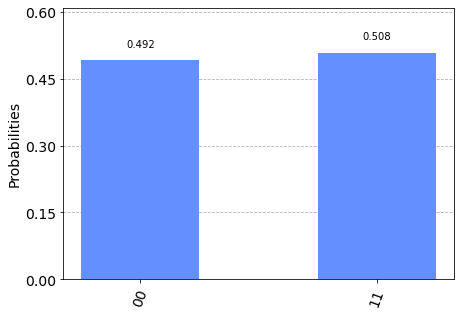

In [16]:
sim_count = measure_sim(qc=qc)
plot_histogram(sim_count)

##### QFT check

In [17]:
def qft_rotations(circuit, n):
    """Add controlled phase gates as per qft on the first n qubits in circuit"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n) # recursion call
    
def swap_registers(circuit, n):
    """Swap Registers as per QFT scheme"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n, transpile_swap = False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

###### For Four Qubit Topology

In [18]:
# Define the topology
n_q, n_e = 4, 2
qr0 = QuantumRegister(n_q, 'qr0')
qr1 = QuantumRegister(n_e, 'qr1')
q_map = {
    "QPU_1" : [Qubit(qr0, i) for i in range(2)],
    "QPU_2" : [Qubit(qr0, i) for i in range(2,n_q)]
#     "QPU_3" : [Qubit(qr0, i) for i in range(3,5)],
#     "QPU_4" : [Qubit(qr0, i) for i in range(5,n_q)],
}
e_map = {
    "QPU_1" : Qubit(qr1, 0),
    "QPU_2" : Qubit(qr1, 1)
#     "QPU_3" : Qubit(qr1, 2),
#     "QPU_4" : Qubit(qr1, 3),
}
q_map, e_map

({'QPU_1': [Qubit(QuantumRegister(4, 'qr0'), 0),
   Qubit(QuantumRegister(4, 'qr0'), 1)],
  'QPU_2': [Qubit(QuantumRegister(4, 'qr0'), 2),
   Qubit(QuantumRegister(4, 'qr0'), 3)]},
 {'QPU_1': Qubit(QuantumRegister(2, 'qr1'), 0),
  'QPU_2': Qubit(QuantumRegister(2, 'qr1'), 1)})

In [19]:
topology = Topology(q_map,e_map)

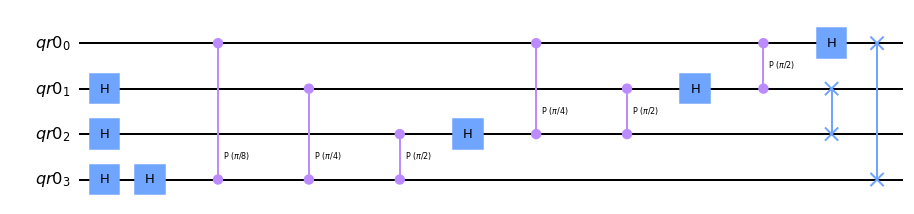

In [20]:
circ_1 = QuantumCircuit(qr0, name="QFT")
for i in range(1,n_q):
    circ_1.h(i)
qft_circ = qft(circ_1, n_q)
qft_circ.draw(output='mpl')

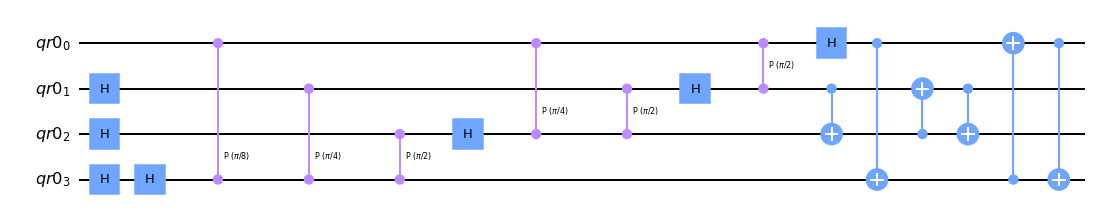

In [21]:
qft_circ.decompose('swap').draw(output='mpl')

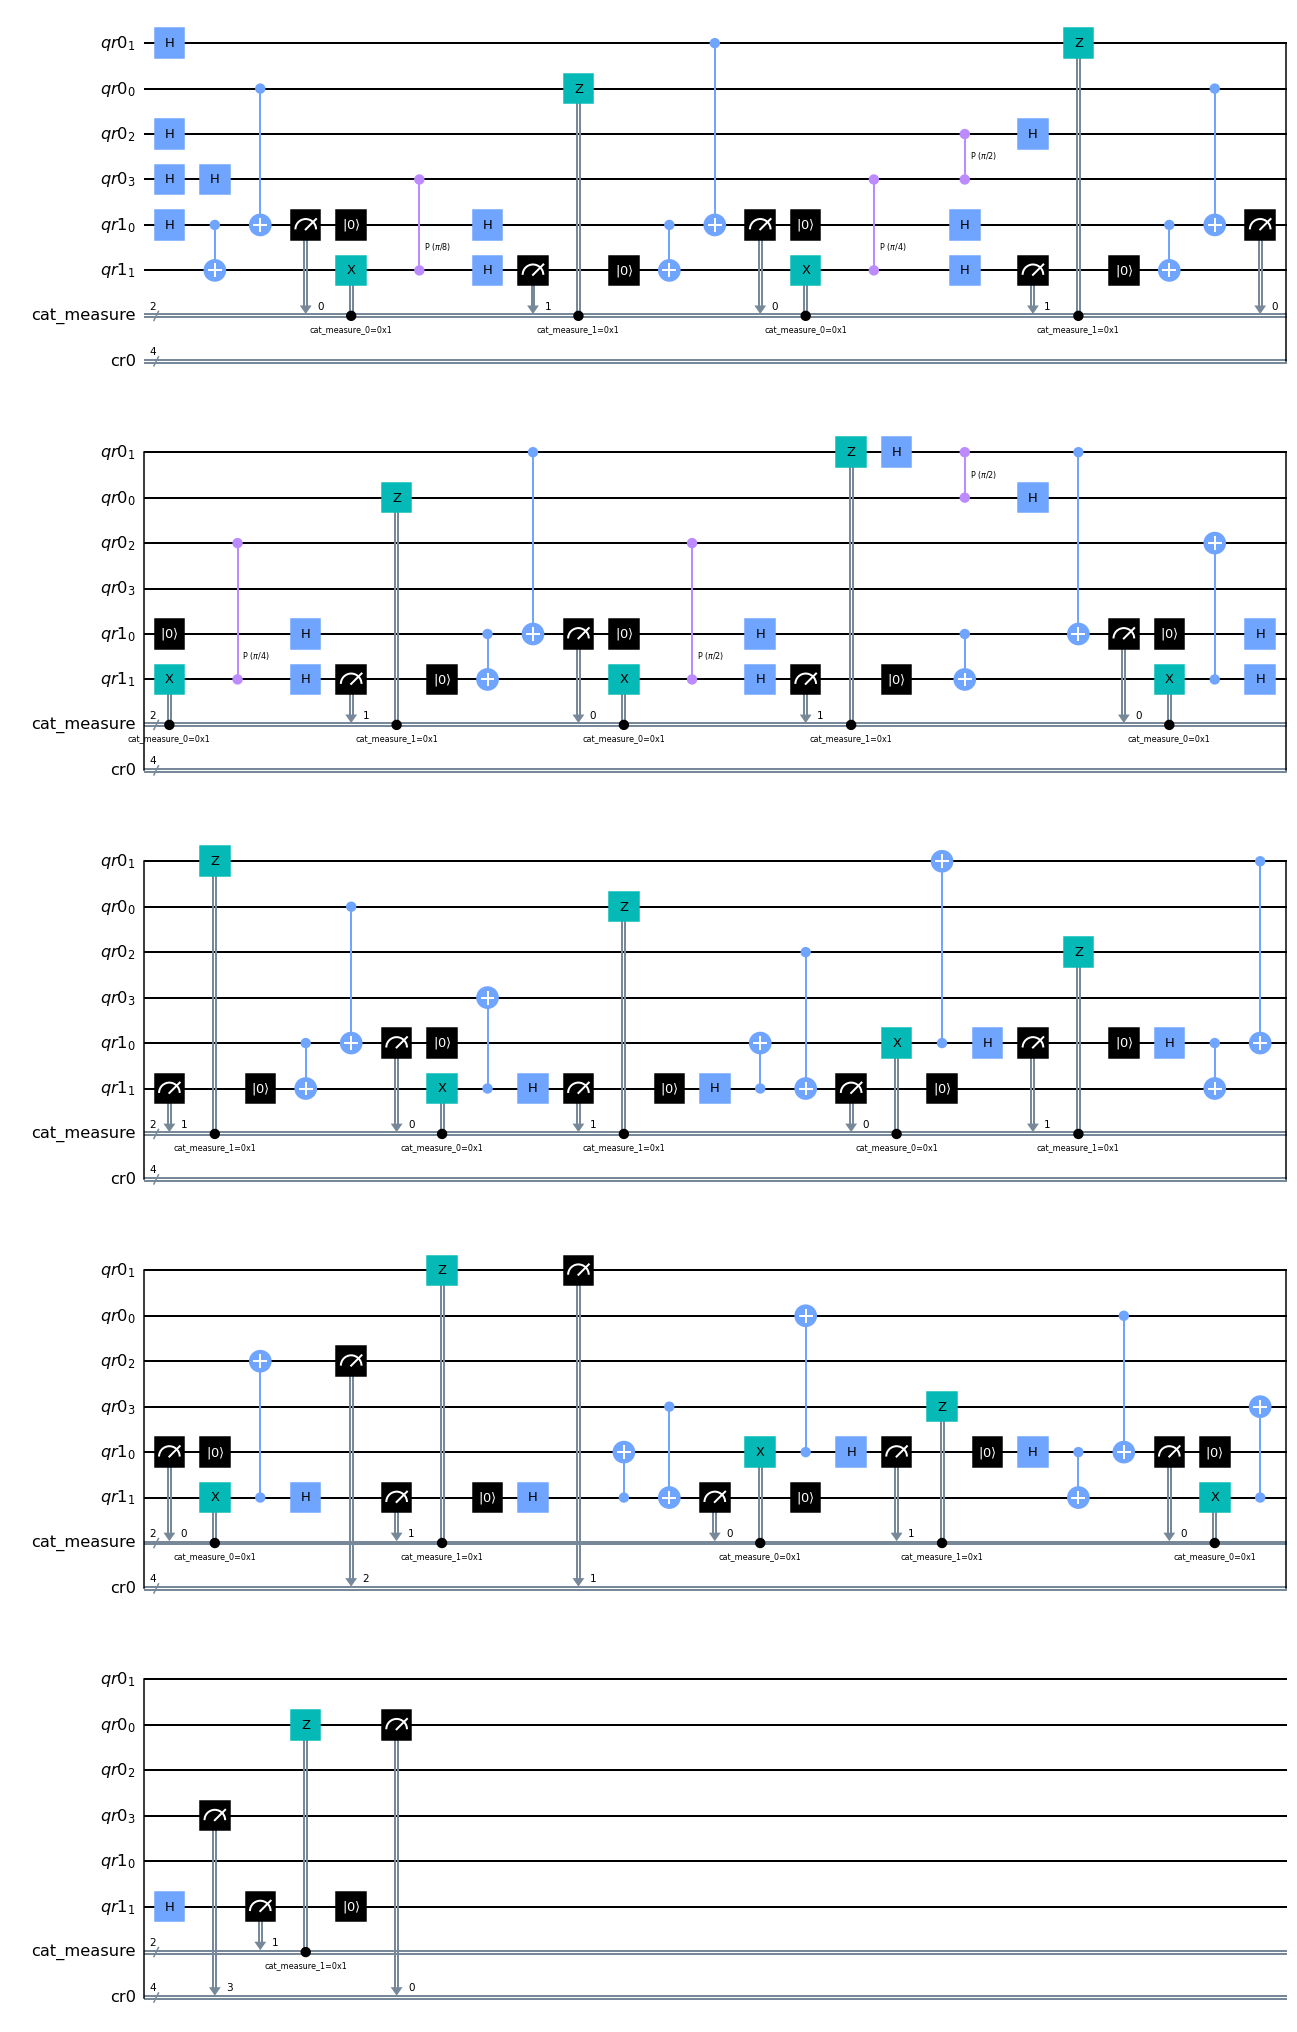

In [22]:
remapper = CircuitRemapper(topology)
dist_circ_1 = remapper.remap_circuit(qft_circ.decompose('swap'))

cr0 = ClassicalRegister(n_q, 'cr0')
dist_circ_1.add_register(cr0)
dist_circ_1.measure(qr0,cr0)
dist_circ_1.draw(output='mpl')

{'1000': 9982, '0000': 10018}


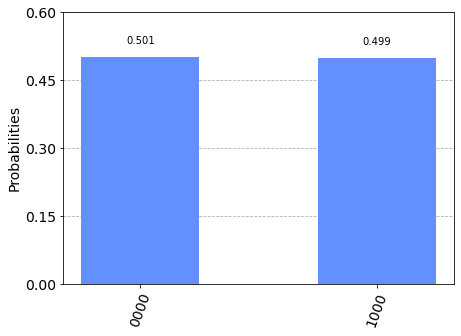

In [23]:
qft_circ.measure_all()
sim_count = measure_sim(qc=qft_circ)
print(sim_count)
plot_histogram(sim_count) 

{'0000': 10005, '1000': 9995}


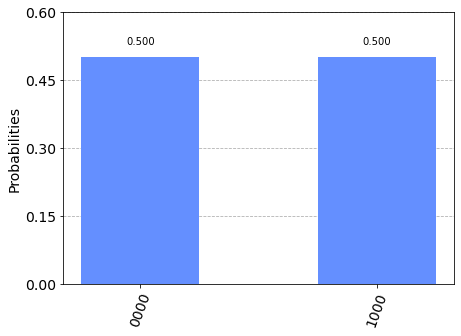

In [24]:
dist_sim_count = measure_sim(qc=dist_circ_1)
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [25]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

###### For 16 Qubit topology

In [30]:
# Define the topology
n_q, n_e = 8, 4
qr0 = QuantumRegister(n_q, 'qr0')
qr1 = QuantumRegister(n_e, 'qr1')
q_map = {
    "QPU_1" : [Qubit(qr0, i) for i in range(2)],
    "QPU_2" : [Qubit(qr0, i) for i in range(2,3)],
    "QPU_3" : [Qubit(qr0, i) for i in range(3,5)],
    "QPU_4" : [Qubit(qr0, i) for i in range(5,n_q)],
}
e_map = {
    "QPU_1" : Qubit(qr1, 0),
    "QPU_2" : Qubit(qr1, 1),
    "QPU_3" : Qubit(qr1, 2),
    "QPU_4" : Qubit(qr1, 3),
}

In [31]:
topology = Topology(q_map,e_map)
for qubit in topology.qubits:
    print("Qubit: {} --------- Host: {}".format(qubit, topology.get_host(qubit)))

Qubit: Qubit(QuantumRegister(8, 'qr0'), 0) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(8, 'qr0'), 1) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(8, 'qr0'), 2) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(8, 'qr0'), 3) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(8, 'qr0'), 4) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(8, 'qr0'), 5) --------- Host: QPU_4
Qubit: Qubit(QuantumRegister(8, 'qr0'), 6) --------- Host: QPU_4
Qubit: Qubit(QuantumRegister(8, 'qr0'), 7) --------- Host: QPU_4


In [32]:
circ_2 = QuantumCircuit(qr0, name="QFT")
for i in range(1,n_q):
    circ_2.h(i)
qft_circ2 = qft(circ_2, n_q)

In [33]:
remapper = CircuitRemapper(topology)
dist_circ_2 = remapper.remap_circuit(qft_circ2.decompose('swap'))

cr0 = ClassicalRegister(n_q, 'cr0')
dist_circ_2.add_register(cr0)
dist_circ_2.measure(qr0,cr0)


{'10000000': 9962, '00000000': 10038}


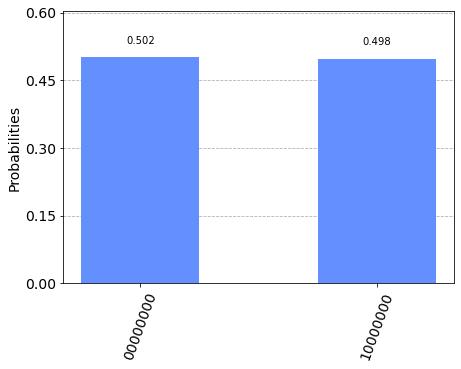

In [34]:
qft_circ2.measure_all()
sim_count = measure_sim(qc=qft_circ2)
print(sim_count)
plot_histogram(sim_count) 

{'10000000': 10117, '00000000': 9883}


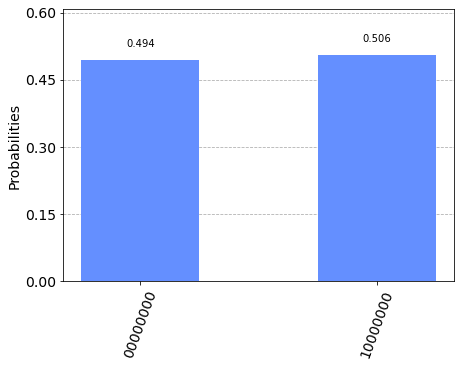

In [35]:
dist_sim_count = measure_sim(qc=dist_circ_2)
sim_dict = CircuitRemapper.collate_measurements(dist_sim_count, n_q)
        
print(sim_dict)
plot_histogram(sim_dict) 

In [36]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()